<h1 style="text-align: center;">Electricity price forecasting by Elmy Centré</h1>

**Data description**

**Index**

**DELIVERY_START** : date et heure de livraison de l'électricité

**Variables explicatives**

**load_forecast** : prévision de consommation totale d'éléctricité en France

**coal_power_available**, **gas_power_available**, **nucelear_power_available** : capacité de production totale d'électricité des centrales à charbon, gaz et nucléaire respectivement,

**wind_power_forecasts_average**, **solar_power_forecasts_average** : moyenne de différentes prévisions de production totale d'électricité éolienne et solaire (respectivement),

**wind_power_forecasts_std**, **solar_power_forecasts_std** : écart-type de ces mêmes prévisions,

**predicted_spot_price** : prévision du prix SPOT de l'électricité issues d'un modèle interne de Elmy. Ce modèle est lancé chaque jour avant la fermeture des enchères SPOT pour le lendemain.


**Variable cible**

**spot_id_delta** : l'écart entre le VWAP des transactions sur le marché infra-journalier (Intraday) et le prix SPOT pour 1MWh d'électricité **(spot_id_delta = Intraday - SPOT)** : si la valeur est positive, le prix Intraday est supérieur au prix SPOT et inversement.

In [ ]:
#Instalattion des packages
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install missingno
!pip install matplotlib
!pip install scikit-learn
!pip install statsmodels
!pip install xgboost

In [4]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
#Importation des libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_regression

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score

__Importation des bases de données__

In [3]:
# Charger le fichier CSV dans un DataFrame
X_dt = pd.read_csv("X_train.csv",sep=",")
Y_dt = pd.read_csv("y_train.csv",sep=",")
X_test = pd.read_csv("X_test.csv",sep=",")

In [4]:
Y_dt

,DELIVERY_START,spot_id_delta
0,2022-01-01 02:00:00+01:00,-36.874770
1,2022-01-01 03:00:00+01:00,-12.643588
2,2022-01-01 04:00:00+01:00,-1.950193
3,2022-01-01 05:00:00+01:00,1.938272
4,2022-01-01 06:00:00+01:00,0.199907
...,...,...
10600,2023-03-29 19:00:00+02:00,6.029303
10601,2023-03-29 20:00:00+02:00,13.576177
10602,2023-03-29 21:00:00+02:00,17.478945
10603,2023-03-29 22:00:00+02:00,17.559407


In [5]:
X_dt

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN
1,2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN
2,2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN
3,2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN
4,2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...
10600,2023-03-29 19:00:00+02:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11
10601,2023-03-29 20:00:00+02:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66
10602,2023-03-29 21:00:00+02:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01
10603,2023-03-29 22:00:00+02:00,47967.0,3386.0,11952.0,38320.0,9636.0,0.0,156.669189,0.000000,136.74


In [17]:
data_merge = pd.merge(Y_dt, X_dt, on="DELIVERY_START")
data_merge.sort_values(['DELIVERY_START'],inplace=True)

notre variable contient 10605 variables

In [9]:
data_merge.head()

,DELIVERY_START,spot_id_delta,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
0,2022-01-01 01:00:00+00:00,-36.874770,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.0,NaN
1,2022-01-01 02:00:00+00:00,-12.643588,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.0,NaN
2,2022-01-01 03:00:00+00:00,-1.950193,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.0,NaN
3,2022-01-01 04:00:00+00:00,1.938272,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.0,NaN
4,2022-01-01 05:00:00+00:00,0.199907,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.0,NaN


In [18]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   DELIVERY_START                 10605 non-null  object 
 1   spot_id_delta                  10605 non-null  float64
 2   load_forecast                  9318 non-null   float64
 3   coal_power_available           10604 non-null  float64
 4   gas_power_available            10604 non-null  float64
 5   nucelear_power_available       10604 non-null  float64
 6   wind_power_forecasts_average   10581 non-null  float64
 7   solar_power_forecasts_average  10581 non-null  float64
 8   wind_power_forecasts_std       10581 non-null  float64
 9   solar_power_forecasts_std      10581 non-null  float64
 10  predicted_spot_price           1846 non-null   float64
dtypes: float64(10), object(1)
memory usage: 911.5+ KB


__Verification des valeurs manquantes et leur gestion__

In [19]:
round((data_merge.isna().sum()/len(data_merge))*100,2)

DELIVERY_START                    0.00
spot_id_delta                     0.00
load_forecast                    12.14
coal_power_available              0.01
gas_power_available               0.01
nucelear_power_available          0.01
wind_power_forecasts_average      0.23
solar_power_forecasts_average     0.23
wind_power_forecasts_std          0.23
solar_power_forecasts_std         0.23
predicted_spot_price             82.59
dtype: float64

<Axes: >

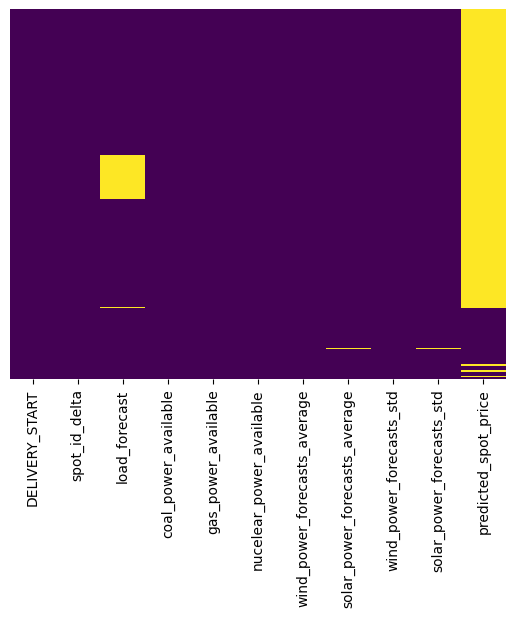

In [10]:
sns.heatmap(data_merge.isnull(),yticklabels=False, cbar=False,cmap='viridis')

In [20]:
# Convertir la colonne DELIVERY_START en format datetime en utilisant utc=True
data_merge['DELIVERY_START'] = pd.to_datetime(data_merge['DELIVERY_START'], utc=True)

__Traitement des valeurs manquantes__

In [21]:
# Créer un imputer IterativeImputer
imputer = IterativeImputer(max_iter=30, random_state=0, sample_posterior=True)

# Sélectionner les colonnes à imputer
columns_to_impute = ['wind_power_forecasts_average',
                                                   'solar_power_forecasts_average','wind_power_forecasts_std',
                                                   'solar_power_forecasts_std','coal_power_available','gas_power_available','nucelear_power_available']
# Imputer les colonnes spécifiées
data_merge[columns_to_impute] = imputer.fit_transform(data_merge[columns_to_impute])

In [22]:
# Création des nouvelles variables temporelles
data_merge['hour'] = data_merge['DELIVERY_START'].dt.hour
data_merge['day_of_week'] = data_merge['DELIVERY_START'].dt.dayofweek

# Création de la variable "jour ouvré"
data_merge['is_workday'] = data_merge['day_of_week'].apply(lambda x: 1 if x < 5 else 0)


#spot_id_delta = Y
# Création des retards et des moyennes glissantes
data_merge['Y_lag_1'] = data_merge['spot_id_delta'].shift(3)
data_merge['Y_rolling_mean_3'] = data_merge['spot_id_delta'].rolling(window=6).mean()
data_merge['Y_rolling_std_3'] = data_merge['spot_id_delta'].rolling(window=6).std()
data_merge['Y_rolling_mean_12'] = data_merge['spot_id_delta'].rolling(window=12).mean()
data_merge['Y_rolling_std_12'] = data_merge['spot_id_delta'].rolling(window=12).std()

# Remplacer les valeurs manquantes uniquement dans les colonnes des retards et moyennes glissantes
data_merge[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3', 'Y_rolling_mean_12', 'Y_rolling_std_12']] = data_merge[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3', 'Y_rolling_mean_12', 'Y_rolling_std_12']].fillna(0)

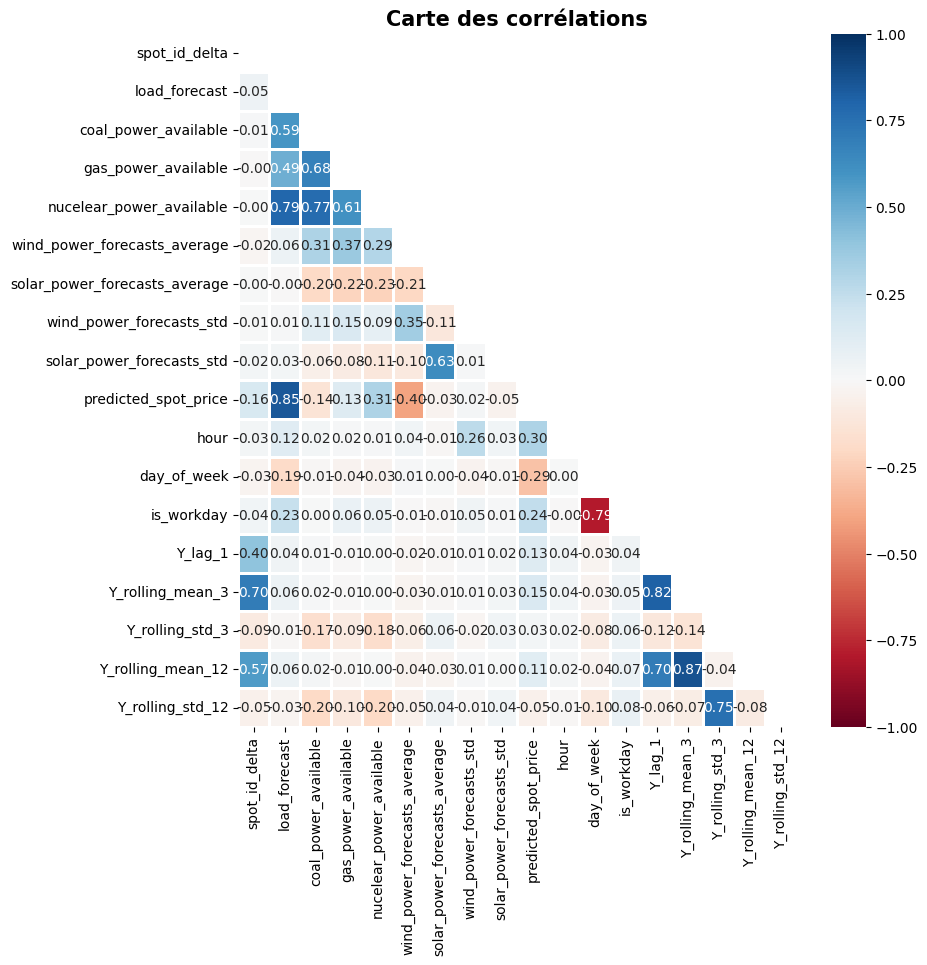

In [11]:
# Carte des corrélations

plt.figure(figsize=(9,9))

mask = np.triu(np.ones_like(data_merge.iloc[:, 1:].corr(), dtype=bool))

sns.heatmap(data_merge.iloc[:, 1:].corr(), 
            mask=mask, center=0, cmap='RdBu', linewidths=1, 
            annot=True, fmt=".2f", vmin=-1, vmax=1
)

plt.title('Carte des corrélations', fontsize=15, fontweight="bold")

plt.show()

In [9]:
######   Nouveau

# Initialisation du seed
seed = 123

# Fonction pour créer les modèles avec paramètres ajustables
def create_models(params=None):
    if params is None:
        params = {
            #'SVR': {},
            #'MLP': {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.0001, 'max_iter': 2000, 'random_state': seed},
            'XGBOOST': {'random_state': seed},
            'GBR': {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_split': 2},
            'RFR': {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 3, 'random_state': seed, 'bootstrap': True}
        }
    models = {
        'SVR': SVR(**params['SVR']),
        'MLP': MLPRegressor(**params['MLP']),
        'XGBOOST': XGBRegressor(**params['XGBOOST']),
        'GBR': GradientBoostingRegressor(**params['GBR']),
        'RFR': RandomForestRegressor(**params['RFR'])

    }
    return models

# Hyperparamètres à ajuster pour chaque modèle
param_grids = {
    'SVR': {'C': np.logspace(-3, 3, 7), 'epsilon': [0.01, 0.1, 1]},
    'MLP': {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001]},
    'XGBOOST': {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]},
    'GBR': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'RFR': {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]}

}

# Fonction d'évaluation des modèles avec ajustement des hyperparamètres
def evaluate_models(models, X_train, Y_train, X_test, Y_test, num_folds=5):
    scoring = 'neg_mean_squared_error'
    results = {}

    for model_name, model in models.items():
        kfold = KFold(n_splits=num_folds)

        # Recherche des meilleurs paramètres si disponible dans le param_grids
        if model_name in param_grids and param_grids[model_name]:
            random_search = RandomizedSearchCV(
                estimator=model,
                param_distributions=param_grids[model_name],
                n_iter=10,  # Limiter le nombre d'itérations pour des résultats rapides
                scoring=scoring,
                cv=kfold,
                random_state=seed,
                n_jobs=-1
            )
            random_search.fit(X_train, Y_train)
            best_model = random_search.best_estimator_
            print(f"Meilleurs paramètres pour {model_name}: {random_search.best_params_}")
        else:
            best_model = model.fit(X_train, Y_train)

        # Calcul des scores de validation croisée
        cv_results = np.sqrt(-1 * cross_val_score(best_model, X_train, Y_train, cv=kfold, scoring=scoring))

        # Calcul des métriques
        results[model_name] = {
            'model': best_model,
            'RMSE train': np.sqrt(mean_squared_error(Y_train, best_model.predict(X_train))),
            'RMSE test': np.sqrt(mean_squared_error(Y_test, best_model.predict(X_test))),
            'Mean CV results': cv_results.mean(),
            'Std CV results': cv_results.std(),
            'R² train': r2_score(Y_train, best_model.predict(X_train)),
            'R² test': r2_score(Y_test, best_model.predict(X_test))
        }

    return pd.DataFrame.from_dict(results, orient='index')

# La variable load_forecast

In [26]:
data_loadf = data_merge.dropna(subset=['load_forecast'])
data_loadf=data_loadf.drop(columns=['predicted_spot_price','solar_power_forecasts_average','Y_rolling_std_3','wind_power_forecasts_std','Y_rolling_std_12'])
round((data_loadf.isna().sum()/len(data_loadf))*100,2)

DELIVERY_START                  0.0
spot_id_delta                   0.0
load_forecast                   0.0
coal_power_available            0.0
gas_power_available             0.0
nucelear_power_available        0.0
wind_power_forecasts_average    0.0
solar_power_forecasts_std       0.0
hour                            0.0
day_of_week                     0.0
is_workday                      0.0
Y_lag_1                         0.0
Y_rolling_mean_3                0.0
Y_rolling_mean_12               0.0
dtype: float64

In [25]:
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype              
---  ------                         --------------  -----              
 0   DELIVERY_START                 10605 non-null  datetime64[ns, UTC]
 1   spot_id_delta                  10605 non-null  float64            
 2   load_forecast                  9318 non-null   float64            
 3   coal_power_available           10605 non-null  float64            
 4   gas_power_available            10605 non-null  float64            
 5   nucelear_power_available       10605 non-null  float64            
 6   wind_power_forecasts_average   10605 non-null  float64            
 7   solar_power_forecasts_average  10605 non-null  float64            
 8   wind_power_forecasts_std       10605 non-null  float64            
 9   solar_power_forecasts_std      10605 non-null  float64            
 10  predicted_spot_price  

In [27]:
# Séparer la variable cible et les variables explicatives
X_loadf_train = data_loadf.drop(columns=['load_forecast', 'DELIVERY_START'])
y_loadf_train = data_loadf['load_forecast']

# Séparer les données d'entraînement et de test
Xlf_train, Xlf_test, ylf_train, ylf_test = train_test_split(X_loadf_train, y_loadf_train, test_size=0.1, random_state=42)


In [29]:
#Standadiser
# Initialisation du scaler
scaler = StandardScaler()
# Appliquer le scaler sur les données d'entraînement
Xlf_train = scaler.fit_transform(Xlf_train)

# Appliquer le même scaler sur les données de test
Xlf_test = scaler.transform(Xlf_test)

In [30]:
# Créer et entraîner le modèle
model = LinearRegression()
model.fit(Xlf_train, ylf_train)

# Faire des prédictions
y_pred = model.predict(Xlf_test)

# Évaluer le modèle
mse = mean_squared_error(ylf_test, y_pred)
r2 = r2_score(ylf_test, y_pred)

# Afficher les résultats
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 37538017.7437744
R^2 Score: 0.6881586244009268


In [31]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(Xlf_train, ylf_train)
y_pred_gb = gb.predict(Xlf_test)
# Évaluer le modèle
mse = mean_squared_error(ylf_test, y_pred_gb)
r2 = r2_score(ylf_test, y_pred_gb)

# Afficher les résultats
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 16138399.19459028
R^2 Score: 0.8659327021698513


In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialiser le modèle RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle
rfr.fit(Xlf_train, ylf_train)

# Prédire les valeurs
y_pred_rfr = rfr.predict(Xlf_test)

# Évaluer le modèle
mse_rfr = mean_squared_error(ylf_test, y_pred_rfr)
r2_rfr = r2_score(ylf_test, y_pred_rfr)

# Afficher les résultats
print(f"Random Forest - Mean Squared Error: {mse_rfr}")
print(f"Random Forest - R^2 Score: {r2_rfr}")


Random Forest - Mean Squared Error: 3986529.3021990336
Random Forest - R^2 Score: 0.9668825138836763


In [ ]:
# Initialisation des paramètres
seed = 123
iter = 2000
lr = 0.001
mdl_lf= create_models()
# Évaluation des modèles
results_metrics_lf = evaluate_models(mdl_lf, Xlf_train, ylf_train, Xlf_test, ylf_test,num_folds=10)
results_metrics_lf


Meilleurs paramètres pour SVR: {'epsilon': 1, 'C': np.float64(1000.0)}


<Axes: >

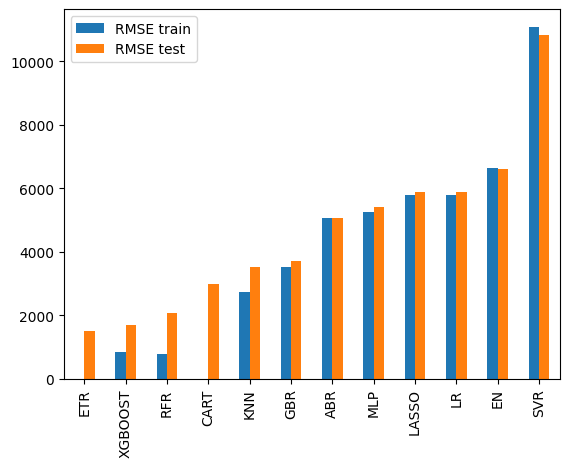

In [116]:
# Affichage des résultats
with pd.option_context('display.precision', 3):
    best_printlf = results_metrics_lf.sort_values(by='RMSE test', ascending=True)

# Comparaison des erreurs d'entraînement et de test
best_printlf[['RMSE train', 'RMSE test']].plot(kind='bar')

In [117]:
best_mdlf=results_metrics_lf.loc['RFR', 'model']

In [33]:
#la base avec les valeurs manquantes 
data_lf_with_na = data_merge[data_merge['load_forecast'].isna()]

#definir les valeurs pour la prediction
Xlf_predi= data_lf_with_na.drop(columns=['DELIVERY_START', 'load_forecast','predicted_spot_price','solar_power_forecasts_average','Y_rolling_std_3','wind_power_forecasts_std','Y_rolling_std_12'])

In [34]:
# Remplir les valeurs manquantes dans le DataFrame d'origine
data_merge.loc[data_merge['load_forecast'].isna(), 'load_forecast'] =rfr.predict(Xlf_predi)

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [37]:
round((data_merge.isna().sum()/len(data_merge))*100,2)

DELIVERY_START                    0.00
spot_id_delta                     0.00
load_forecast                     0.00
coal_power_available              0.00
gas_power_available               0.00
nucelear_power_available          0.00
wind_power_forecasts_average      0.00
solar_power_forecasts_average     0.00
wind_power_forecasts_std          0.00
solar_power_forecasts_std         0.00
predicted_spot_price             82.59
hour                              0.00
day_of_week                       0.00
is_workday                        0.00
Y_lag_1                           0.00
Y_rolling_mean_3                  0.00
Y_rolling_std_3                   0.00
Y_rolling_mean_12                 0.00
Y_rolling_std_12                  0.00
dtype: float64

# Traitement de la variable predicted_spot_price

In [39]:
data_predspot = data_merge.dropna(subset=['predicted_spot_price'])

round((data_predspot.isna().sum()/len(data_predspot))*100,2)

DELIVERY_START                   0.0
spot_id_delta                    0.0
load_forecast                    0.0
coal_power_available             0.0
gas_power_available              0.0
nucelear_power_available         0.0
wind_power_forecasts_average     0.0
solar_power_forecasts_average    0.0
wind_power_forecasts_std         0.0
solar_power_forecasts_std        0.0
predicted_spot_price             0.0
hour                             0.0
day_of_week                      0.0
is_workday                       0.0
Y_lag_1                          0.0
Y_rolling_mean_3                 0.0
Y_rolling_std_3                  0.0
Y_rolling_mean_12                0.0
Y_rolling_std_12                 0.0
dtype: float64

In [41]:
# Séparer la variable cible et les variables explicatives
X_Spot_price_train = data_predspot.drop(columns=['predicted_spot_price', 'DELIVERY_START'])
y_Spot_price_train = data_predspot['predicted_spot_price']

# Séparer les données d'entraînement et de test
Xsp_train, Xsp_test, ysp_train, ysp_test = train_test_split(X_Spot_price_train, y_Spot_price_train, test_size=0.1, random_state=42)

In [42]:
#Standadiser
# Initialisation du scaler
scaler = StandardScaler()

# Appliquer le scaler sur les données d'entraînement
Xsp_train = scaler.fit_transform(Xsp_train)

# Appliquer le même scaler sur les données de test
Xsp_test = scaler.transform(Xsp_test)

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialiser le modèle RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle
rf.fit(Xsp_train, ysp_train)

# Prédire les valeurs
y_pred_rf = rf.predict(Xsp_test)

# Évaluer le modèle
mse_rf = mean_squared_error(ysp_test, y_pred_rf)
r2_rf = r2_score(ysp_test, y_pred_rf)

# Afficher les résultats
print(f"Random Forest - Mean Squared Error: {mse_rf}")
print(f"Random Forest - R^2 Score: {r2_rf}")

Random Forest - Mean Squared Error: 109.78325022378382
Random Forest - R^2 Score: 0.9169340182215082


In [44]:
from sklearn.ensemble import GradientBoostingRegressor

gb2 = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb2.fit(Xsp_train, ysp_train)
y_pred_gb2 = gb2.predict(Xsp_test)
# Évaluer le modèle
mse = mean_squared_error(ysp_test, y_pred_gb2)
r2 = r2_score(ysp_test, y_pred_gb2)

# Afficher les résultats
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 99.37103438787321
R^2 Score: 0.9248122776931166


In [124]:
# Initialisation des paramètres
seed = 123
iter = 2000
lr = 0.001

# Création des modèles
model_sp = create_models()

# Évaluation des modèles
results_metrics_sp = evaluate_models(model_sp, Xsp_train, ysp_train, Xsp_test, ysp_test,num_folds=10)
results_metrics_sp

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the 

,model,RMSE train,RMSE test,Mean CV results,Std CV results,R² train,R² test
LR,LinearRegression(),1.495299e+01,15.183937,15.048787,0.935501,0.802267,0.825556
LASSO,Lasso(),1.533806e+01,15.524058,15.357105,1.084997,0.791952,0.817653
EN,ElasticNet(),1.797946e+01,19.046188,18.000429,1.497364,0.714125,0.725525
KNN,KNeighborsRegressor(),1.064765e+01,15.087117,14.215181,0.943188,0.899739,0.827774
CART,DecisionTreeRegressor(random_state=123),0.000000e+00,15.045012,14.732869,1.273533,1.000000,0.828734
SVR,SVR(),1.968450e+01,21.187408,20.441142,1.534513,0.657333,0.660341
MLP,"MLPRegressor(max_iter=2000, random_state=123)",6.709198e+00,9.286223,10.001123,0.520001,0.960193,0.934752
ABR,"(DecisionTreeRegressor(max_depth=3, random_sta...",1.347169e+01,14.985034,14.352583,0.876075,0.839503,0.830096
XGBOOST,"XGBRegressor(base_score=None, booster=None, ca...",7.014862e-01,7.745315,7.814145,0.394075,0.999565,0.954609
GBR,([DecisionTreeRegressor(criterion='friedman_ms...,7.792328e+00,9.782168,9.478186,0.683234,0.946302,0.927597


<Axes: >

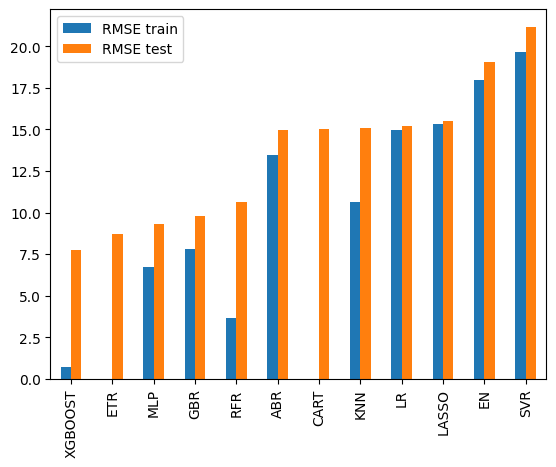

In [125]:
# Affichage des résultats
with pd.option_context('display.precision', 3):
    best_print_sp = results_metrics_sp.sort_values(by='RMSE test', ascending=True)

# Comparaison des erreurs d'entraînement et de test
best_print_sp[['RMSE train', 'RMSE test']].plot(kind='bar')

In [126]:
#Choix du modèle
best_mdsp=results_metrics_sp.loc['GBR', 'model']

In [45]:
#la base avec les valeurs manquantes 
data_sp_with_na = data_merge[data_merge['predicted_spot_price'].isna()]

#definir les valeurs pour la prediction
Xsp_predi= data_sp_with_na.drop(columns=['DELIVERY_START','predicted_spot_price'])

In [46]:
# Remplir les valeurs manquantes dans le DataFrame d'origine
data_merge.loc[data_merge['predicted_spot_price'].isna(), 'predicted_spot_price'] =gb2.predict(Xsp_predi)

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [47]:
round((data_merge.isna().sum()/len(data_merge))*100,2)

DELIVERY_START                   0.0
spot_id_delta                    0.0
load_forecast                    0.0
coal_power_available             0.0
gas_power_available              0.0
nucelear_power_available         0.0
wind_power_forecasts_average     0.0
solar_power_forecasts_average    0.0
wind_power_forecasts_std         0.0
solar_power_forecasts_std        0.0
predicted_spot_price             0.0
hour                             0.0
day_of_week                      0.0
is_workday                       0.0
Y_lag_1                          0.0
Y_rolling_mean_3                 0.0
Y_rolling_std_3                  0.0
Y_rolling_mean_12                0.0
Y_rolling_std_12                 0.0
dtype: float64

In [36]:
#Save the results to a CSV file
data_merge.to_csv('datau.csv')

# la variable spot_id_delta

In [58]:
#
# Séparer la variable cible et les variables explicatives
#X_Spot_delta_train = data_merge.drop(columns=['Y_rolling_std_12','Y_rolling_mean_12','Y_rolling_std_3','Y_rolling_mean_3','Y_lag_1','spot_id_delta', 'DELIVERY_START','gas_power_available','nucelear_power_available','solar_power_forecasts_average'])

In [89]:
# Séparer la variable cible et les variables explicatives
X_Spot_delta_train = data_merge.drop(columns=['Y_rolling_std_12','Y_rolling_mean_12','Y_rolling_std_3','Y_rolling_mean_3','Y_lag_1','spot_id_delta', 'DELIVERY_START','solar_power_forecasts_average'])

In [90]:
# Calcul de la puissance totale disponible
X_Spot_delta_train.loc[:, 'total_power_available_sp'] = (
    X_Spot_delta_train['coal_power_available'] +
    X_Spot_delta_train['gas_power_available'] +
    X_Spot_delta_train['nucelear_power_available']
)

# Calcul du ratio puissance/charge
X_Spot_delta_train.loc[:, 'power_to_load_ratio'] = X_Spot_delta_train['total_power_available_sp'] / X_Spot_delta_train['load_forecast']


In [91]:
# Variables de retard
X_Spot_delta_train['predicted_spot_price_lag_1'] = X_Spot_delta_train['predicted_spot_price'].shift(1).ffill()
X_Spot_delta_train['predicted_spot_price_lag_7'] = X_Spot_delta_train['predicted_spot_price'].shift(7).ffill()
X_Spot_delta_train['predicted_spot_price_lag_30'] = X_Spot_delta_train['predicted_spot_price'].shift(30).ffill()

# Moyenne mobile et écart-type
X_Spot_delta_train['predicted_spot_price_ma_7d'] = X_Spot_delta_train['predicted_spot_price'].rolling(window=7).mean().ffill()
X_Spot_delta_train['predicted_spot_price_std_7d'] = X_Spot_delta_train['predicted_spot_price'].rolling(window=7).std().ffill()
X_Spot_delta_train['predicted_spot_price_range_7d'] = (X_Spot_delta_train['predicted_spot_price'].rolling(window=7).max() - 
                                                       X_Spot_delta_train['predicted_spot_price'].rolling(window=7).min()).ffill()

# EMA et changement en pourcentage
X_Spot_delta_train['predicted_spot_price_ema_7d'] = X_Spot_delta_train['predicted_spot_price'].ewm(span=7, adjust=False).mean().ffill()
X_Spot_delta_train['predicted_spot_price_pct_change'] = X_Spot_delta_train['predicted_spot_price'].pct_change().fillna(0)

# Momentum et variation entre prévisions successives
X_Spot_delta_train['predicted_spot_price_momentum_7d'] = X_Spot_delta_train['predicted_spot_price'].diff(7).fillna(0)
X_Spot_delta_train['predicted_spot_price_diff'] = X_Spot_delta_train['predicted_spot_price'].diff().fillna(0)


In [92]:
# Instead of inplace=True with method chaining, use direct assignment
X_Spot_delta_train['predicted_spot_price_lag_1'] = X_Spot_delta_train['predicted_spot_price_lag_1'].ffill()
X_Spot_delta_train['predicted_spot_price_lag_7'] = X_Spot_delta_train['predicted_spot_price_lag_7'].ffill()
X_Spot_delta_train['predicted_spot_price_lag_30'] = X_Spot_delta_train['predicted_spot_price_lag_30'].ffill()

X_Spot_delta_train['predicted_spot_price_ma_7d'] = X_Spot_delta_train['predicted_spot_price_ma_7d'].ffill()
X_Spot_delta_train['predicted_spot_price_std_7d'] = X_Spot_delta_train['predicted_spot_price_std_7d'].ffill()
X_Spot_delta_train['predicted_spot_price_range_7d'] = X_Spot_delta_train['predicted_spot_price_range_7d'].ffill()
X_Spot_delta_train['predicted_spot_price_ema_7d'] = X_Spot_delta_train['predicted_spot_price_ema_7d'].ffill()

# For columns where you fill with a specific value, also use direct assignment
X_Spot_delta_train['predicted_spot_price_pct_change'] = X_Spot_delta_train['predicted_spot_price_pct_change'].fillna(0)
X_Spot_delta_train['predicted_spot_price_momentum_7d'] = X_Spot_delta_train['predicted_spot_price_momentum_7d'].fillna(0)
X_Spot_delta_train['predicted_spot_price_diff'] = X_Spot_delta_train['predicted_spot_price_diff'].fillna(0)


In [108]:
# Création des retards et des moyennes glissantes
X_Spot_delta_train['Y_lag_1'] = X_Spot_delta_train['load_forecast'].shift(1)
X_Spot_delta_train['Y_rolling_mean_3'] = X_Spot_delta_train['load_forecast'].rolling(window=3).mean()
X_Spot_delta_train['Y_rolling_std_3'] = X_Spot_delta_train['load_forecast'].rolling(window=3).std()


# Remplacer les valeurs manquantes uniquement dans les colonnes des retards et moyennes glissantes
X_Spot_delta_train[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3']] = X_Spot_delta_train[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3']].fillna(0)

In [109]:
X_Spot_delta_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10605 entries, 0 to 10604
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   load_forecast                     10605 non-null  float64
 1   coal_power_available              10605 non-null  float64
 2   gas_power_available               10605 non-null  float64
 3   nucelear_power_available          10605 non-null  float64
 4   wind_power_forecasts_average      10605 non-null  float64
 5   wind_power_forecasts_std          10605 non-null  float64
 6   solar_power_forecasts_std         10605 non-null  float64
 7   predicted_spot_price              10605 non-null  float64
 8   hour                              10605 non-null  int32  
 9   day_of_week                       10605 non-null  int32  
 10  is_workday                        10605 non-null  int64  
 11  total_power_available_sp          10605 non-null  float64
 12  powe

In [110]:
round((X_Spot_delta_train.isna().sum()/len(X_Spot_delta_train))*100,2)

load_forecast                       0.0
coal_power_available                0.0
gas_power_available                 0.0
nucelear_power_available            0.0
wind_power_forecasts_average        0.0
wind_power_forecasts_std            0.0
solar_power_forecasts_std           0.0
predicted_spot_price                0.0
hour                                0.0
day_of_week                         0.0
is_workday                          0.0
total_power_available_sp            0.0
power_to_load_ratio                 0.0
predicted_spot_price_lag_1          0.0
predicted_spot_price_lag_7          0.0
predicted_spot_price_lag_30         0.0
predicted_spot_price_ma_7d          0.0
predicted_spot_price_std_7d         0.0
predicted_spot_price_range_7d       0.0
predicted_spot_price_ema_7d         0.0
predicted_spot_price_pct_change     0.0
predicted_spot_price_momentum_7d    0.0
predicted_spot_price_diff           0.0
Y_lag_1                             0.0
Y_rolling_mean_3                    0.0


In [96]:
# Créer un imputer IterativeImputer
imputer = IterativeImputer(max_iter=30, random_state=0, sample_posterior=True)

# Sélectionner les colonnes à imputer
columns_to_imputes = ['predicted_spot_price_lag_1',
                                                   'predicted_spot_price_lag_7','predicted_spot_price_lag_30',
                                                   'predicted_spot_price_ma_7d','predicted_spot_price_std_7d','predicted_spot_price_range_7d']
# Imputer les colonnes spécifiées
X_Spot_delta_train[columns_to_imputes] = imputer.fit_transform(X_Spot_delta_train[columns_to_imputes])

In [98]:
#Save the results to a CSV file
X_Spot_delta_train.to_csv('X_Spot_delta_train.csv')

In [111]:
y_Spot_delta_train = data_merge['spot_id_delta']

# Séparer les données d'entraînement et de test
Xdel_train, Xdel_test, ydel_train, ydel_test = train_test_split(X_Spot_delta_train, y_Spot_delta_train, test_size=0.1, random_state=42)

In [112]:
#Standadiser
# Initialisation du scaler
scaler = StandardScaler()

# Appliquer le scaler sur les données d'entraînement
Xdel_train = scaler.fit_transform(Xdel_train)

# Appliquer le même scaler sur les données de test
Xdel_test = scaler.transform(Xdel_test)

In [113]:
#LN
# Initialiser le modèle de régression linéaire
lr_spot = LinearRegression()

# Entraîner le modèle sur les données d'entraînement
lr_spot.fit(Xdel_train, ydel_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_lr = lr_spot.predict(Xdel_test)

# Évaluer le modèle
mse_lr = mean_squared_error(ydel_test, y_pred_lr)
r2_lr = r2_score(ydel_test, y_pred_lr)

# Afficher les résultats
print(f"Linear Regression - Mean Squared Error: {mse_lr}")
print(f"Linear Regression - R^2 Score: {r2_lr}")


Linear Regression - Mean Squared Error: 1067.9615542101826
Linear Regression - R^2 Score: 0.02203682689318287


In [120]:
# Initialiser le modèle RandomForestRegressor avec des hyperparamètres ajustés
RF_spot = RandomForestRegressor(n_estimators=300, random_state=123)

# Entraîner le modèle
RF_spot.fit(Xdel_train, ydel_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_sp = RF_spot.predict(Xdel_test)

# Évaluer le modèle
mse_rfp = mean_squared_error(ydel_test, y_pred_sp)
r2_rfp = r2_score(ydel_test, y_pred_sp)

# Afficher les résultats
print(f"Random Forest - Mean Squared Error: {mse_rfp}")
print(f"Random Forest - R^2 Score: {r2_rfp}")


Random Forest - Mean Squared Error: 494.67608461485685
Random Forest - R^2 Score: 0.5470108530940698


In [114]:
#GBR
# Initialiser le modèle Gradient Boosting Regressor avec des hyperparamètres ajustés
gbr_spot = GradientBoostingRegressor(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=42)

# Entraîner le modèle
gbr_spot.fit(Xdel_train, ydel_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_gbr = gbr_spot.predict(Xdel_test)

# Évaluer le modèle
mse_gbr = mean_squared_error(ydel_test, y_pred_gbr)
r2_gbr = r2_score(ydel_test, y_pred_gbr)

# Afficher les résultats
print(f"Gradient Boosting Regressor - Mean Squared Error: {mse_gbr}")
print(f"Gradient Boosting Regressor - R^2 Score: {r2_gbr}")


Gradient Boosting Regressor - Mean Squared Error: 650.4503459474622
Gradient Boosting Regressor - R^2 Score: 0.40436387268486373


In [69]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialiser le modèle MLP Regressor avec des hyperparamètres ajustés
mlp_spot = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, activation='relu', solver='adam', random_state=42)

# Entraîner le modèle
mlp_spot.fit(Xdel_train, ydel_train)

# Prédire les valeurs sur l'ensemble de test
y_pred_mlp = mlp_spot.predict(Xdel_test)

# Évaluer le modèle
mse_mlp = mean_squared_error(ydel_test, y_pred_mlp)
r2_mlp = r2_score(ydel_test, y_pred_mlp)

# Afficher les résultats
print(f"MLP Regressor - Mean Squared Error: {mse_mlp}")
print(f"MLP Regressor - R^2 Score: {r2_mlp}")


MLP Regressor - Mean Squared Error: 650.970568978264
MLP Regressor - R^2 Score: 0.40388748946308894


C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


# Exemple d'utilisation
params = {
    'LR': {},  # Modèle par défaut
    'LASSO': {'alpha': 0.5},  # Ajuster l'alpha pour Lasso
    'EN': {'alpha': 0.1, 'l1_ratio': 0.7},  # Paramètres pour ElasticNet
    'MLP': {'random_state': seed, 'max_iter': 3000, 'learning_rate_init': 0.01}  # Paramètres pour MLP
}

In [132]:
# Création des modèles avec les paramètres définis
model_del = create_models()

# Évaluation des modèles
results_metric_del = evaluate_models(model_del, Xdel_train, ydel_train, Xdel_test, ydel_test,num_folds=10)
results_metric_del


,model,RMSE train,RMSE test,Mean CV results,Std CV results,R² train,R² test
LR,LinearRegression(),2.005795e+01,13.251533,19.858746,13.948822,0.730118,0.839195
LASSO,Lasso(),2.075212e+01,13.403083,19.450812,12.013490,0.711115,0.835496
EN,ElasticNet(),2.406641e+01,18.126772,22.305431,11.087839,0.611472,0.699110
KNN,KNeighborsRegressor(),2.257956e+01,16.976380,23.580549,13.857786,0.657996,0.736089
CART,DecisionTreeRegressor(random_state=123),0.000000e+00,20.522834,26.820843,18.037503,1.000000,0.614307
SVR,SVR(),3.026572e+01,22.251267,27.228325,13.728329,0.385528,0.546605
MLP,"MLPRegressor(max_iter=2000, random_state=123)",1.904500e+01,13.188623,23.192137,20.662286,0.756689,0.840718
ABR,"(DecisionTreeRegressor(max_depth=3, random_sta...",1.821057e+01,19.186641,27.436366,16.124084,0.777542,0.662895
XGBOOST,"XGBRegressor(base_score=None, booster=None, ca...",4.122789e+00,12.273342,22.705078,13.679745,0.988598,0.862059
GBR,([DecisionTreeRegressor(criterion='friedman_ms...,1.018467e+01,12.746474,21.856635,14.702238,0.930418,0.851219


<Axes: >

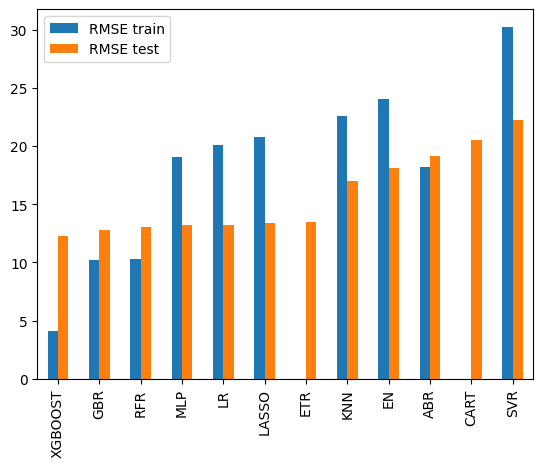

In [133]:
# Affichage des résultats
with pd.option_context('display.precision', 3):
    best_print_del = results_metric_del.sort_values(by='RMSE test', ascending=True)

# Comparaison des erreurs d'entraînement et de test
best_print_del[['RMSE train', 'RMSE test']].plot(kind='bar')

In [134]:
# Appel du meilleur modèle
best_model_del = results_metric_del.loc['GBR', 'model']  # Exemple : MLP comme meilleur modèle
# Prédiction avec le meilleur modèle sur de nouvelles données
#y_pred = best_model.predict(X_new)

# Traitement de la base X_test

In [57]:
dt_test = pd.read_csv("X_test.csv",sep=",")
X_test=dt_test

In [202]:
X_test['DELIVERY_START'] = pd.to_datetime(X_test['DELIVERY_START'])
# Création des nouvelles variables temporelles
X_test['hour'] = X_test['DELIVERY_START'].dt.hour
X_test['day_of_week'] = X_test['DELIVERY_START'].dt.dayofweek
X_test['month'] = X_test['DELIVERY_START'].dt.month

# Création de la variable "jour ouvré"
X_test['is_workday'] = X_test['day_of_week'].apply(lambda x: 1 if x < 5 else 0)


#spot_id_delta = Y
# Création des retards et des moyennes glissantes
X_test['Y_lag_1'] = X_test['load_forecast'].shift(3)
X_test['Y_rolling_mean_3'] = X_test['load_forecast'].rolling(window=6).mean()
X_test['Y_rolling_std_3'] = X_test['load_forecast'].rolling(window=6).std()
X_test['Y_rolling_mean_3'] = X_test['load_forecast'].rolling(window=6).mean()
X_test['Y_rolling_std_12'] = X_test['load_forecast'].rolling(window=6).std()

# Remplacer les valeurs manquantes uniquement dans les colonnes des retards et moyennes glissantes
X_test[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3']] = X_test[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3']].fillna(0)

In [ ]:
# Création des nouvelles variables temporelles
data_merge['hour'] = data_merge['DELIVERY_START'].dt.hour
data_merge['day_of_week'] = data_merge['DELIVERY_START'].dt.dayofweek

# Création de la variable "jour ouvré"
data_merge['is_workday'] = data_merge['day_of_week'].apply(lambda x: 1 if x < 5 else 0)


#spot_id_delta = Y
# Création des retards et des moyennes glissantes
data_merge['Y_lag_1'] = data_merge['spot_id_delta'].shift(3)
data_merge['Y_rolling_mean_3'] = data_merge['spot_id_delta'].rolling(window=6).mean()
data_merge['Y_rolling_std_3'] = data_merge['spot_id_delta'].rolling(window=6).std()
data_merge['Y_rolling_mean_12'] = data_merge['spot_id_delta'].rolling(window=12).mean()
data_merge['Y_rolling_std_12'] = data_merge['spot_id_delta'].rolling(window=12).std()

# Remplacer les valeurs manquantes uniquement dans les colonnes des retards et moyennes glissantes
data_merge[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3', 'Y_rolling_mean_12', 'Y_rolling_std_12']] = data_merge[['Y_lag_1', 'Y_rolling_mean_3', 'Y_rolling_std_3', 'Y_rolling_mean_12', 'Y_rolling_std_12']].fillna(0)

In [204]:
# Sélectionner les colonnes à imputer
columns_to_impute_test = ['solar_power_forecasts_average','solar_power_forecasts_std']
# Imputer les colonnes spécifiées
X_test[columns_to_impute_test] = imputer.fit_transform(X_test[columns_to_impute_test])

In [205]:
data_predspot_test = X_test.dropna(subset=['predicted_spot_price'])

In [206]:
# Séparer la variable cible et les variables explicatives
X_Spot_test_train = data_predspot_test.drop(columns=['predicted_spot_price', 'DELIVERY_START'])
y_Spot_test_train = data_predspot_test['predicted_spot_price']

# Séparer les données d'entraînement et de test
Xsptest_train, Xsptest_test, ysptest_train, ysptest_test = train_test_split(X_Spot_test_train, y_Spot_test_train, test_size=0.1, random_state=42)

In [207]:
#Standadiser

# Appliquer le scaler sur les données d'entraînement
Xsptest_train = scaler.fit_transform(Xsptest_train)

# Appliquer le même scaler sur les données de test
Xsptest_test = scaler.transform(Xsptest_test)

In [208]:
# Création des modèles
model_sp_test = create_models()

# Évaluation des modèles
results_metrics_sp_test = evaluate_models(model_sp_test, Xsptest_train, ysptest_train, Xsptest_test, ysptest_test,num_folds=10)
results_metrics_sp_test

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the 

,model,RMSE train,RMSE test,Mean CV results,Std CV results,R² train,R² test
LR,LinearRegression(),1.831369e+01,18.840768,18.430728,0.722278,0.584572,0.578393
LASSO,Lasso(),1.866031e+01,18.857791,18.728787,0.797286,0.568697,0.577630
EN,ElasticNet(),2.025293e+01,20.128243,20.302938,0.828668,0.491934,0.518803
KNN,KNeighborsRegressor(),1.005023e+01,12.624762,13.206357,0.733102,0.874889,0.810697
CART,DecisionTreeRegressor(random_state=123),0.000000e+00,15.505143,17.017308,0.893434,1.000000,0.714463
SVR,SVR(),1.749646e+01,18.605473,18.033619,0.845194,0.620820,0.588857
MLP,"MLPRegressor(max_iter=2000, random_state=123)",7.814966e+00,10.888129,10.181416,0.449428,0.924352,0.859195
ABR,"(DecisionTreeRegressor(max_depth=3, random_sta...",1.533961e+01,17.084519,16.220210,0.529459,0.708544,0.653330
XGBOOST,"XGBRegressor(base_score=None, booster=None, ca...",1.967955e+00,7.893984,8.287807,0.439331,0.995203,0.925988
GBR,([DecisionTreeRegressor(criterion='friedman_ms...,1.026184e+01,11.952884,11.782084,0.453086,0.869565,0.830310


<Axes: >

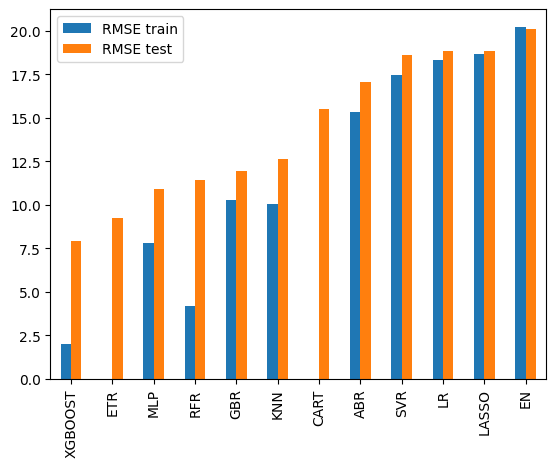

In [209]:
# Affichage des résultats
with pd.option_context('display.precision', 3):
    best_print_sp_test = results_metrics_sp_test.sort_values(by='RMSE test', ascending=True)

# Comparaison des erreurs d'entraînement et de test
best_print_sp_test[['RMSE train', 'RMSE test']].plot(kind='bar')

In [210]:
# Appel du meilleur modèle
best_model_sp_test = results_metrics_sp_test.loc['MLP', 'model'] 

In [211]:
#la base avec les valeurs manquantes 
data_sp_test_with_na = X_test[X_test['predicted_spot_price'].isna()]

#definir les valeurs pour la prediction
Xsp_test_predi= data_sp_test_with_na.drop(columns=['DELIVERY_START','predicted_spot_price'])

In [213]:
# Remplir les valeurs manquantes dans le DataFrame d'origine
X_test.loc[X_test['predicted_spot_price'].isna(), 'predicted_spot_price'] =best_model_sp_test.predict(Xsp_test_predi)

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


In [214]:
y_test_pred=best_model_del.predict(X_test.drop(columns=['DELIVERY_START']))
resultat_test = pd.DataFrame({
    'DELIVERY_START': X_test['DELIVERY_START'],  # Assuming this column exists
    'spot_id_delta': y_test_pred
})

C:\Users\boric\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


In [215]:
resultat_test.head(10)

,DELIVERY_START,spot_id_delta
0,2023-04-02 00:00:00+02:00,2.013607
1,2023-04-02 01:00:00+02:00,-63.545014
2,2023-04-02 02:00:00+02:00,162.231603
3,2023-04-02 03:00:00+02:00,162.231603
4,2023-04-02 04:00:00+02:00,162.231603
5,2023-04-02 05:00:00+02:00,162.231603
6,2023-04-02 06:00:00+02:00,162.231603
7,2023-04-02 07:00:00+02:00,158.227044
8,2023-04-02 08:00:00+02:00,152.494813
9,2023-04-02 09:00:00+02:00,152.494813


In [217]:
#Save the results to a CSV file
resultat_test.to_csv('delivery_start_with.csv', index=False)

In [212]:
X_test.head(10)

,DELIVERY_START,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,hour,day_of_week,month,is_workday,Y_lag_1,Y_rolling_mean_3,Y_rolling_std_3
0,2023-04-02 00:00:00+02:00,45814.0,3386.0,10902.0,36705.0,6359.0,0.0,56.764535,0.000000,NaN,0,6,4,0,0.0,0.000000,0.000000
1,2023-04-02 01:00:00+02:00,44084.0,3386.0,10902.0,36705.0,6469.0,0.0,54.262133,0.000000,NaN,1,6,4,0,45814.0,0.000000,0.000000
2,2023-04-02 02:00:00+02:00,43281.0,3386.0,10902.0,36705.0,6511.0,0.0,78.105928,0.000000,NaN,2,6,4,0,44084.0,44393.000000,1294.462437
3,2023-04-02 03:00:00+02:00,40825.0,3386.0,10902.0,36705.0,6628.0,0.0,78.187557,0.000000,NaN,3,6,4,0,43281.0,42730.000000,1697.931388
4,2023-04-02 04:00:00+02:00,39181.0,3386.0,10902.0,36705.0,6700.0,0.0,96.765484,0.000000,NaN,4,6,4,0,40825.0,41095.666667,2063.357781
5,2023-04-02 05:00:00+02:00,38928.0,3386.0,10902.0,36705.0,6750.0,0.0,133.267741,0.000000,NaN,5,6,4,0,39181.0,39644.666667,1029.996278
6,2023-04-02 06:00:00+02:00,39181.0,3386.0,10902.0,36705.0,6808.0,0.0,148.852429,0.000000,NaN,6,6,4,0,38928.0,39096.666667,146.069618
7,2023-04-02 07:00:00+02:00,40070.0,3386.0,10902.0,36705.0,6816.0,76.0,194.708606,1.150447,NaN,7,6,4,0,39181.0,39393.000000,599.790797
8,2023-04-02 08:00:00+02:00,41653.0,3386.0,10902.0,36705.0,6798.0,806.0,262.002351,6.050982,NaN,8,6,4,0,40070.0,40301.333333,1252.131117
9,2023-04-02 09:00:00+02:00,44137.0,3386.0,10902.0,36705.0,6933.0,2404.0,274.430105,47.362046,NaN,9,6,4,0,41653.0,41953.333333,2050.066422
